In [2]:
%load_ext autoreload
%autoreload 2
import os
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".99"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

# import pandas as pd
import dcmnet
import sys

sys.path.append("/home/boittier/jaxeq/dcmnet")
# print(sys.path)
from dcmnet.models import DCM1, DCM2, DCM3, DCM4, dcm1_params, dcm2_params, dcm3_params, dcm4_params
from dcmnet.modules import MessagePassingModel
from dcmnet.data import prepare_datasets

import numpy as np

def atom_centered_dipole(dcm, com, q):
    dipole_out = np.zeros(3)
    for i, _ in enumerate(dcm):
        dipole_out += q[i] * (_ - com)
    # print(dipole_out*2.5417464519)
    return np.linalg.norm(dipole_out)* 4.80320

import jax
import jax.numpy as jnp
import pickle
from tensorboardX import SummaryWriter
import time
from dcmnet.utils import safe_mkdir
from dcmnet.training import train_model
from dcmnet.training_dipole import train_model_dipo
from pathlib import Path
from dcmnet.data import prepare_batches, prepare_datasets
from dcmnet.utils import apply_model
from dcmnet.plotting import evaluate_dc, plot_esp, plot_model
import optax
from dcmnet.analysis import create_model_and_params
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

devices = jax.local_devices()
print(devices)
print(jax.default_backend())
print(jax.devices())



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[CpuDevice(id=0)]
cpu
[CpuDevice(id=0)]


<Figure size 640x480 with 0 Axes>

<Figure size 100x100 with 0 Axes>

In [3]:
data_key, train_key = jax.random.split(jax.random.PRNGKey(0), 2)
train_data, valid_data = prepare_datasets(
    data_key,
    0,
    6907,
    [
                Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-6907-3.npz", 
        # Path("/pchem-data/meuwly/boittier/home/jaxeq/") / "data/qm9-esp-dip-40000-0.npz"#"data/qm9-esp-dip-6907-3.npz", 
    ],
    clean=True
)


R (6907, 60, 3)
Z (6907, 60)
N (6907,)
D (6907,)
com (6907, 3)
Dxyz (6907, 3)
mono (6907, 60, 1)
esp (6907, 3200)
id (6907,)
n_grid (6907,)
vdw_surface (6907, 3200, 3)
n_failed: 286
0 6621
creating_mask
6621


In [4]:
valid_batches = prepare_batches(data_key, valid_data, 1, include_id=True)

In [5]:
len(valid_data["Z"])

6621

In [1934]:
N = 300
random_ids = [random.randint(0, len(valid_batches)) for _ in range(N)]

In [1935]:
# for _ in list((ddir / "vdwr14").glob("*/best*pkl")):
#     print("restart="+str(_))
#     print("sbatch --export=restart=$restart restart.sh")
#     print()

In [1936]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

In [1937]:
files = {_.parents[0].name: _ for _ in list(ddir.glob("test2/*/best*"))}
KEYS = list(files.keys())
for i, _ in enumerate(KEYS):
    print(i, _)

0 20240926-195014dcm-2-w-10000.0-re-False-ptTrue
1 20240926-195056dcm-2-w-10000.0-re-False-ptTrue
2 20240926-195338dcm-3-w-10000.0-re-False-ptTrue
3 20240926-195425dcm-3-w-10000.0-re-False-ptTrue
4 20240926-200343dcm-4-w-10000.0-re-False-ptTrue
5 20240926-201827dcm-4-w-10000.0-re-False-ptFalse
6 20240926-201855dcm-2-w-10000.0-re-False-ptFalse
7 20240926-201913dcm-3-w-10000.0-re-False-ptFalse
8 20240926-201914dcm-3-w-10000.0-re-False-ptFalse
9 20240926-201945dcm-2-w-10000.0-re-False-ptFalse
10 20240926-203255dcm-4-w-10000.0-re-False-ptTrue
11 20240926-203519dcm-4-w-10000.0-re-False-ptFalse
12 20240926-215000dcm-1-w-10000.0-re-False-ptFalse
13 20240926-215005dcm-1-w-10000.0-re-False-ptFalse


In [1938]:
p = files[KEYS[3]]
print(p)
model, params = create_model_and_params(p)
model

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test2/20240926-195425dcm-3-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 3.0, 'include_pseudotensors': True, 'debug': False}


MessagePassingModel(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 3
    include_pseudotensors = True
)

In [1939]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(random_ids):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=False,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)



100%|████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:20<00:00,  1.23it/s]


In [1940]:
0.5*10000 * ((1.49/627.5)**2)/2

0.014095649275408328

In [1941]:
((0.0197 / 10000) * 2)**0.5 * 627.5

1.2455519358902702

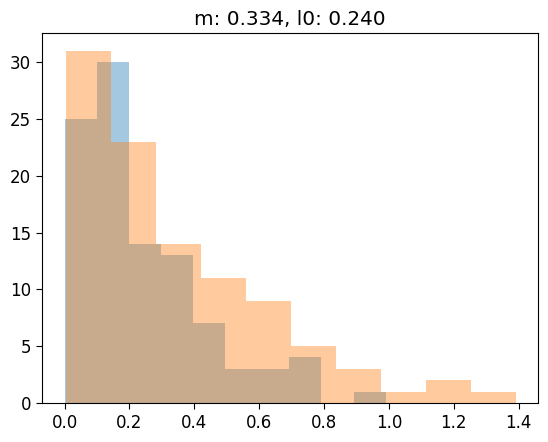

In [1942]:
m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [1943]:
import pandas as pd
df_ = pd.DataFrame({"i": indexes, "m": m.flatten(), "l0": l0.flatten(), "dm": dm, "dl0": dl0})
df_["dif"] = df_["m"] - df_["l0"]
df_["difd"] = df_["dm"] - df_["dl0"]
df_.describe()

i           m          l0          dm         dl0  \
count   100.000000  100.000000  100.000000  100.000000  100.000000   
mean   3754.590000    1.154486    1.175884    0.333811    0.240127   
std    1700.841474    0.458283    0.359494    0.300089    0.191872   
min     148.000000    0.498120    0.590198    0.004174    0.000501   
25%    2604.500000    0.839320    0.896443    0.104780    0.101430   
50%    4014.000000    1.053489    1.110681    0.242869    0.183981   
75%    5087.500000    1.387362    1.378512    0.511719    0.333218   
max    6558.000000    2.820784    2.083155    1.391095    0.989963   

              dif        difd  
count  100.000000  100.000000  
mean    -0.021398    0.093684  
std      0.470956    0.344587  
min     -1.023690   -0.608107  
25%     -0.290925   -0.104688  
50%     -0.067847    0.015086  
75%      0.270364    0.283744  
max      1.213783    1.255246

In [1944]:
good = list(df_.sort_values("m", ascending=True)["i"])
print(len(good))
df_.sort_values("m", ascending=True)[:10].describe() #.sort_values("dif", ascending=True)

100


i          m         l0         dm        dl0        dif  \
count    10.000000  10.000000  10.000000  10.000000  10.000000  10.000000   
mean   3813.400000   0.620658   0.962622   0.135805   0.120039  -0.341965   
std    2063.937187   0.077899   0.211785   0.109242   0.095711   0.231444   
min     666.000000   0.498120   0.774165   0.009668   0.026770  -0.903469   
25%    2145.500000   0.566863   0.806533   0.034896   0.069294  -0.416121   
50%    4249.000000   0.620239   0.889040   0.132724   0.086595  -0.266644   
75%    5495.750000   0.698706   1.077444   0.191556   0.160215  -0.222198   
max    6527.000000   0.709854   1.401589   0.329300   0.344821  -0.066528   

            difd  
count  10.000000  
mean    0.015765  
std     0.134441  
min    -0.174154  
25%    -0.048700  
50%    -0.009155  
75%     0.019479  
max     0.302530

  0%|                                                                                                        | 0/5 [00:00<?, ?it/s]

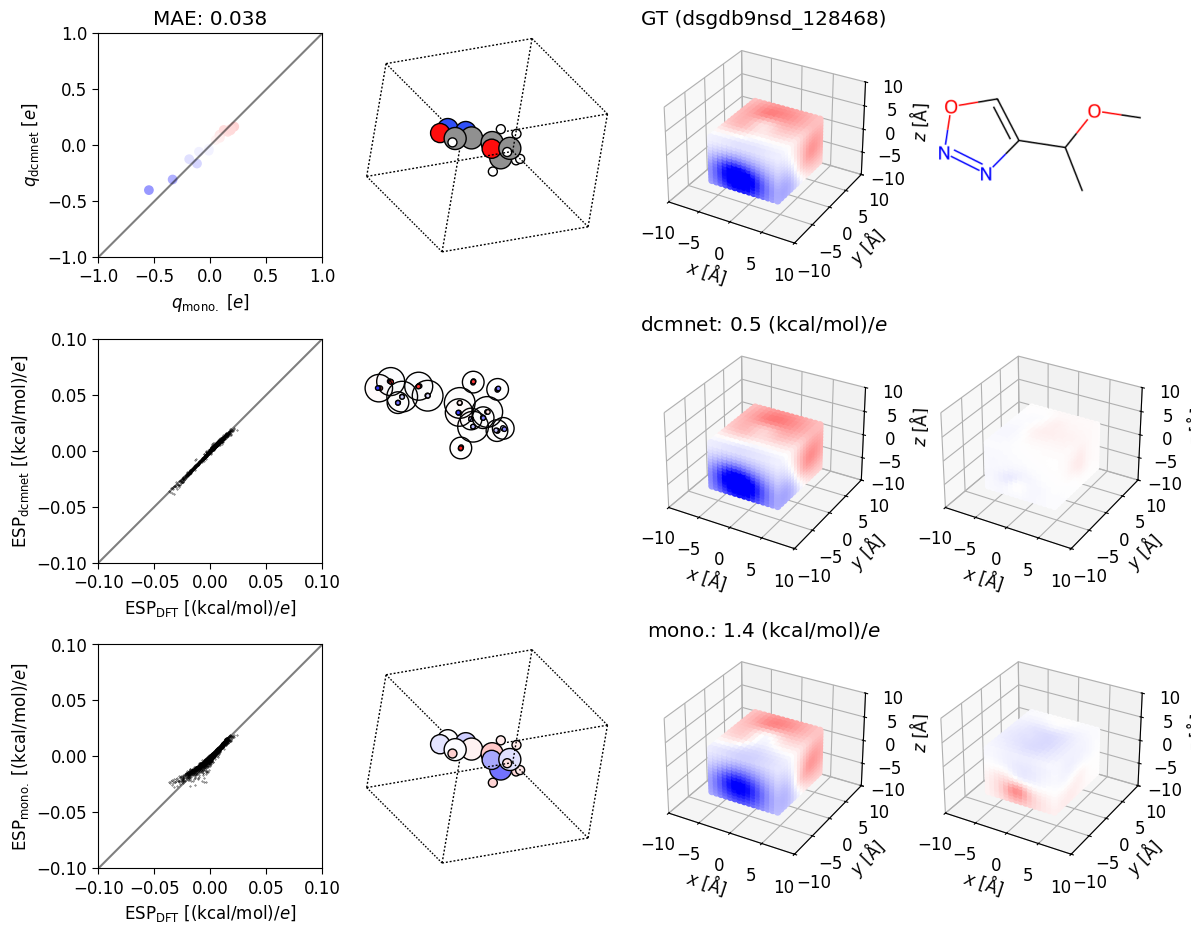

 20%|███████████████████▏                                                                            | 1/5 [00:06<00:24,  6.09s/it]

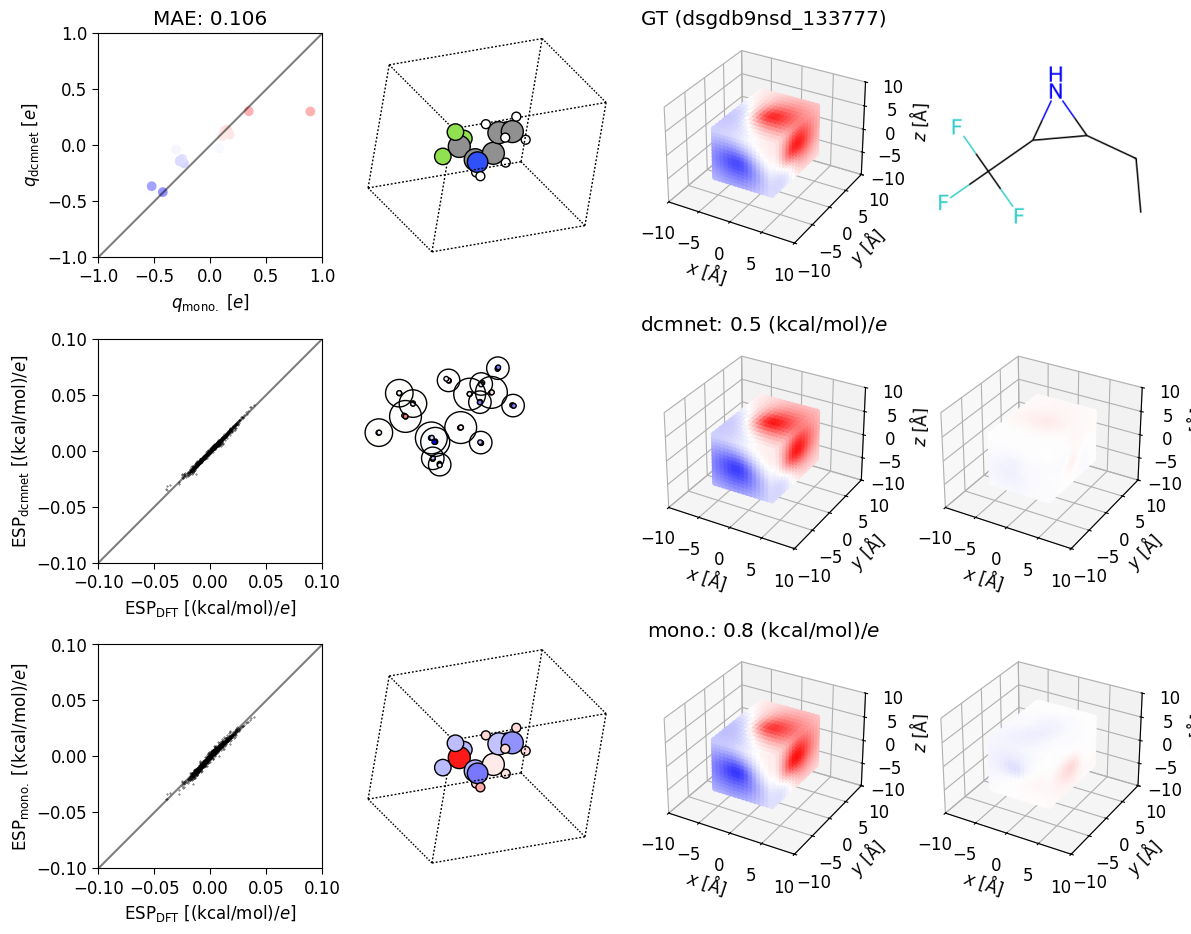

 40%|██████████████████████████████████████▍                                                         | 2/5 [00:12<00:18,  6.13s/it]

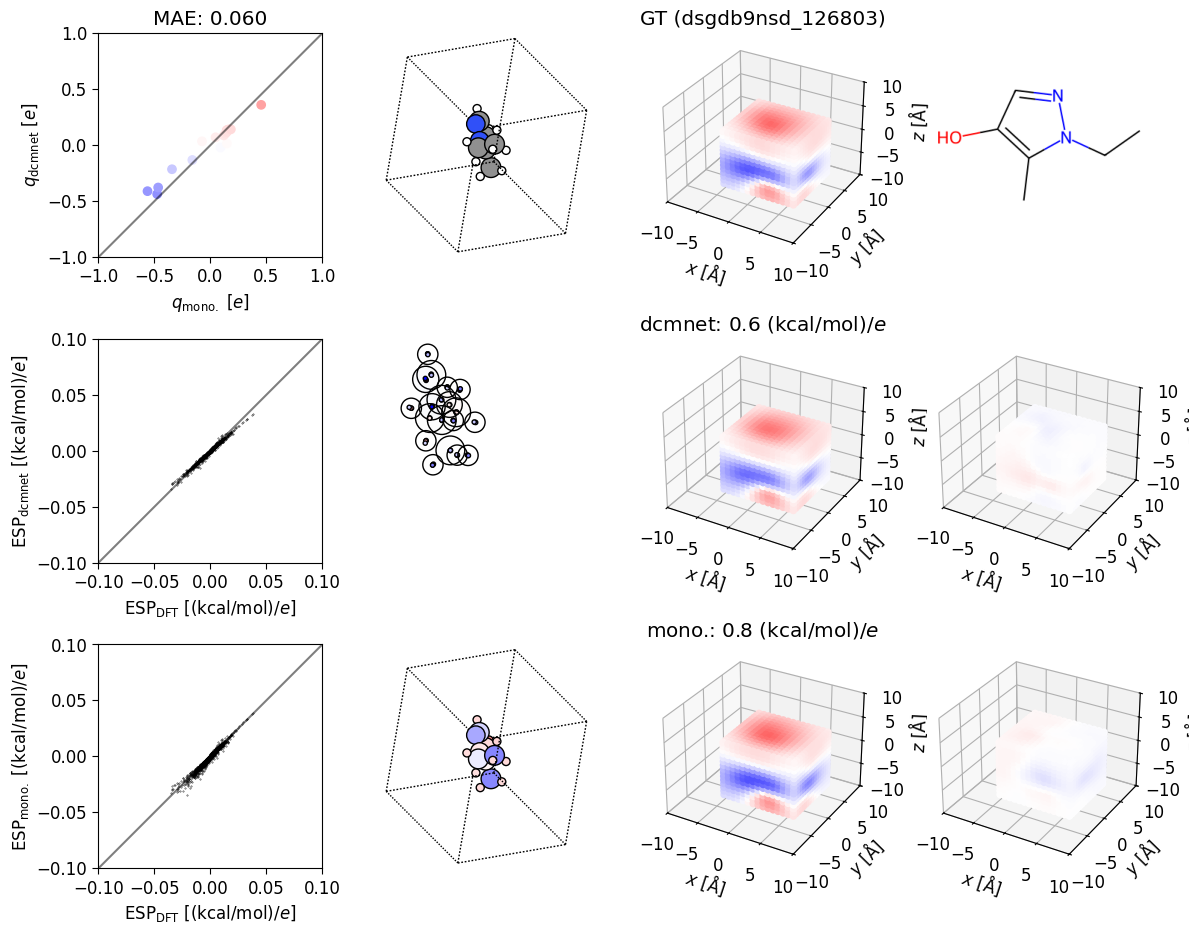

 60%|█████████████████████████████████████████████████████████▌                                      | 3/5 [00:18<00:12,  6.16s/it]

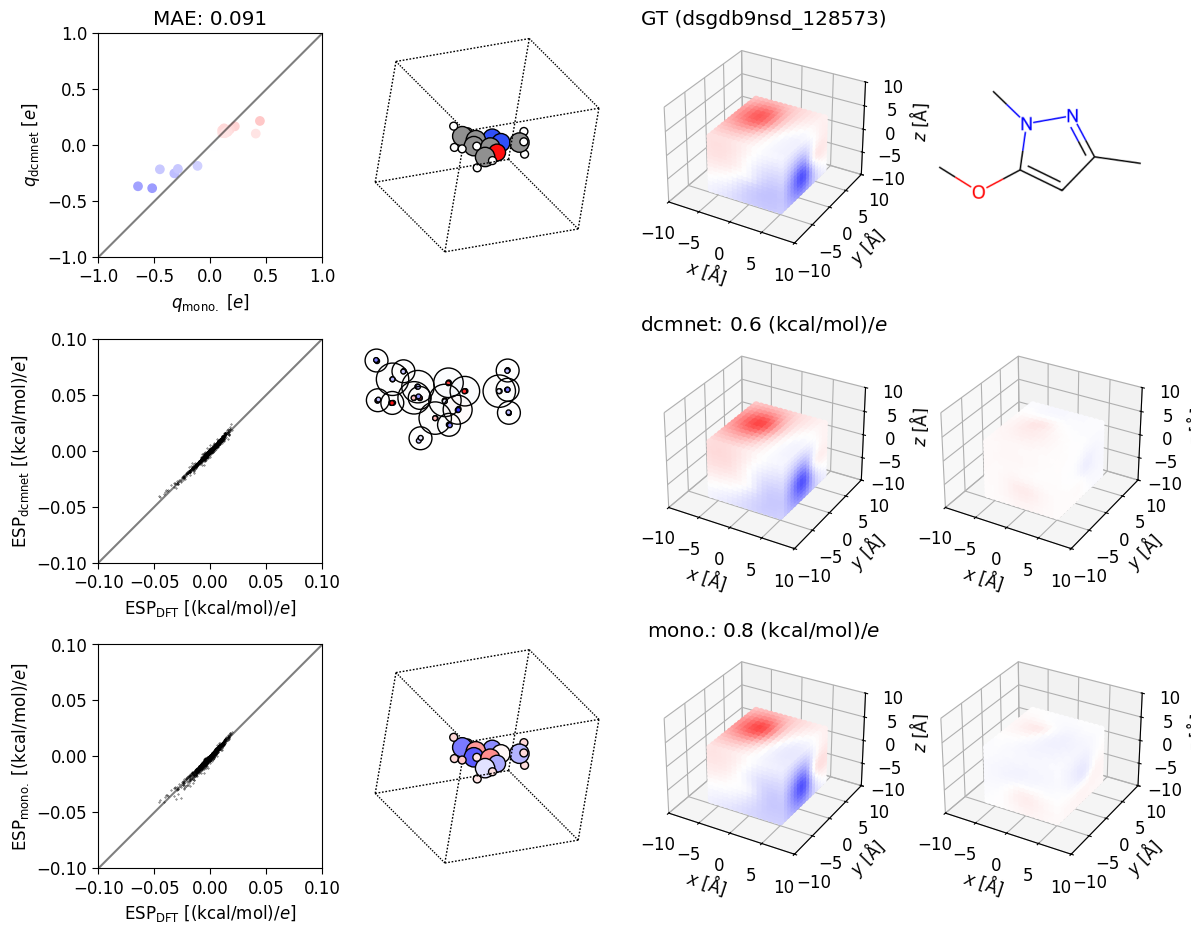

 80%|████████████████████████████████████████████████████████████████████████████▊                   | 4/5 [00:26<00:07,  7.03s/it]

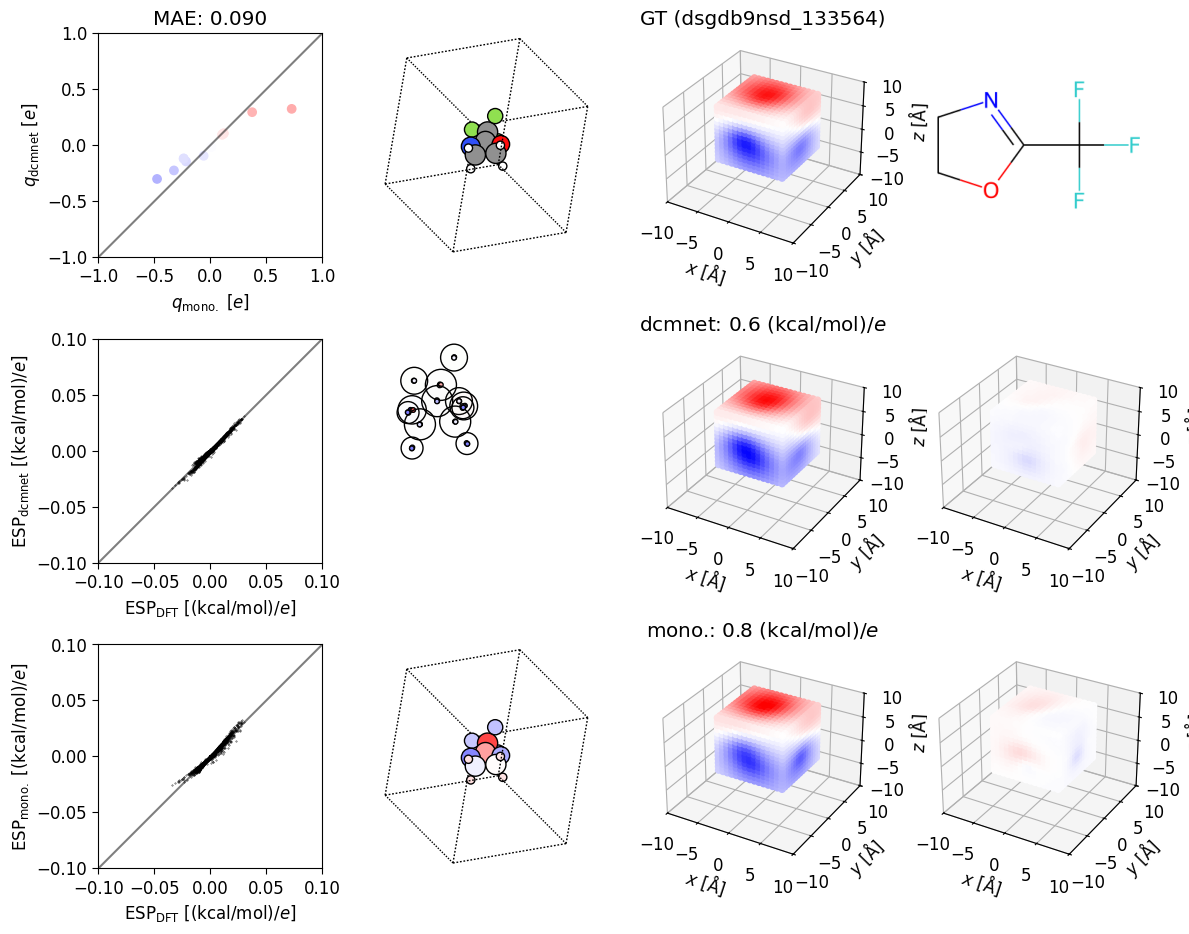

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:32<00:00,  6.57s/it]


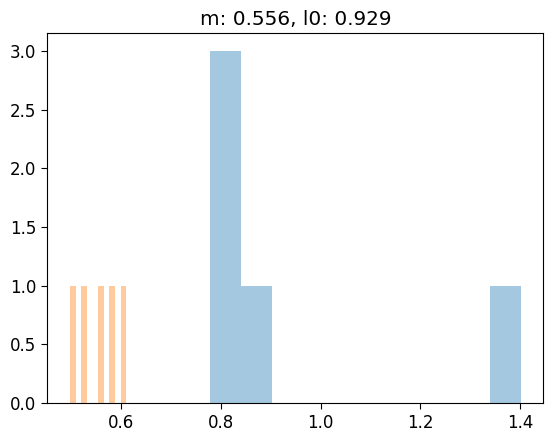

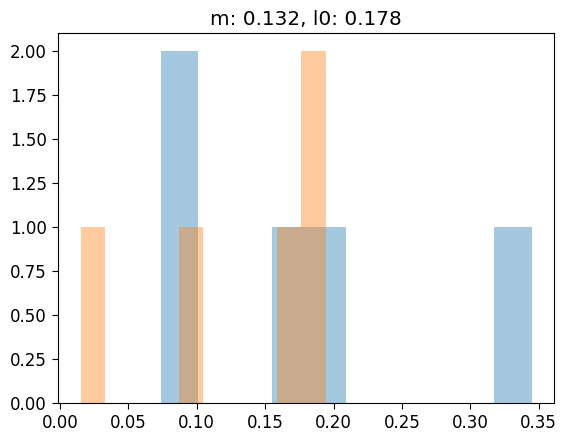

In [1945]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(good[:5]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [1790]:

bad = list(df_[df_["dif"] > 0].sort_values("dif", ascending=False)["i"])
len(bad)
df_[df_["dif"] > 0].describe()

i          m         l0         dm        dl0        dif  \
count    52.000000  52.000000  52.000000  52.000000  52.000000  52.000000   
mean   3269.153846   1.419076   1.051393   0.489671   0.249175   0.367683   
std    1921.289338   0.444341   0.327553   0.328058   0.172146   0.292489   
min      87.000000   0.774443   0.613452   0.061522   0.004818   0.008483   
25%    1506.750000   1.116998   0.818692   0.235739   0.094575   0.135244   
50%    3550.500000   1.316390   0.962945   0.434111   0.263894   0.269178   
75%    4729.500000   1.605231   1.180807   0.663799   0.324822   0.541486   
max    6599.000000   3.191001   2.119163   1.613310   0.675594   1.297165   

            difd  
count  52.000000  
mean    0.240496  
std     0.306029  
min    -0.335320  
25%     0.017369  
50%     0.247235  
75%     0.437229  
max     1.128569

  0%|                                                                                                        | 0/5 [00:00<?, ?it/s]

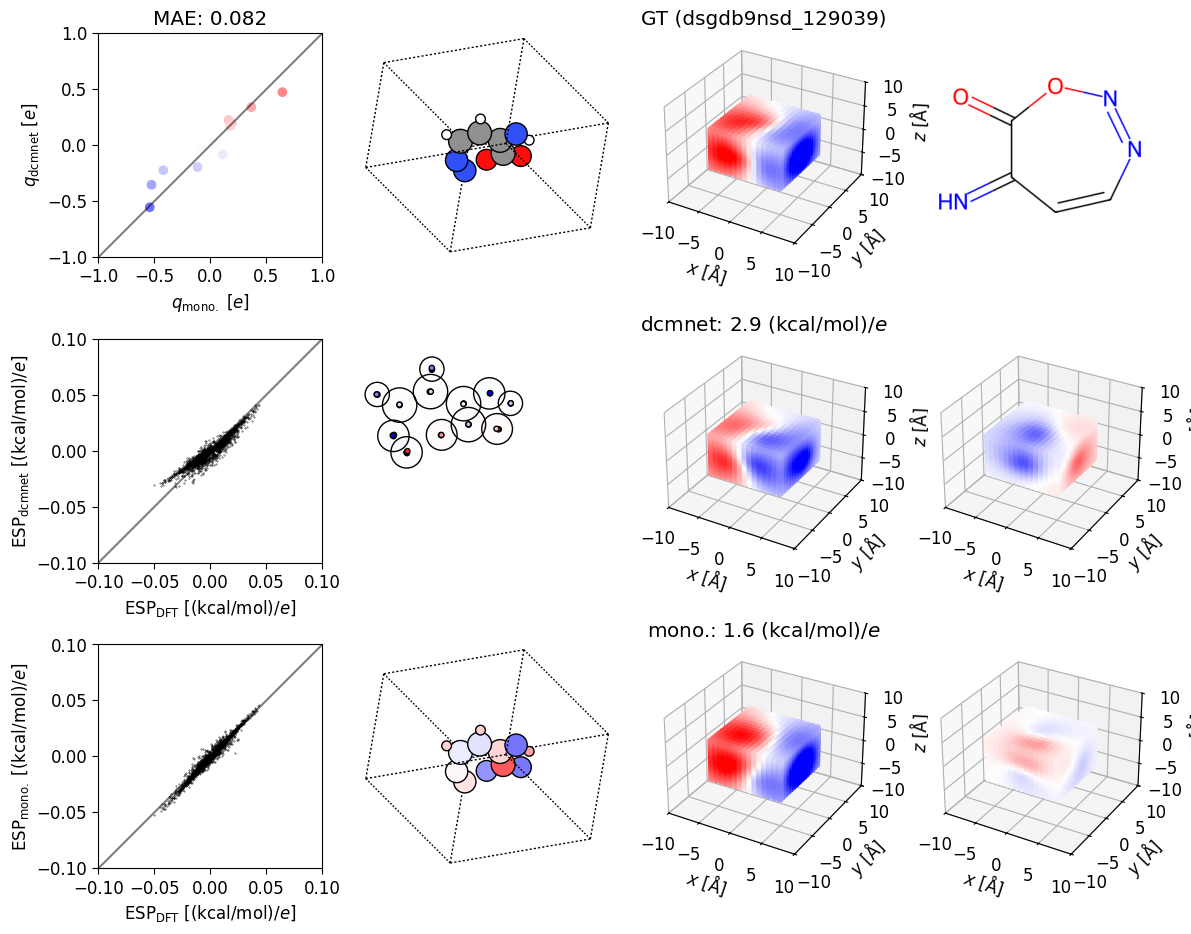

 20%|███████████████████▏                                                                            | 1/5 [00:05<00:23,  5.84s/it]

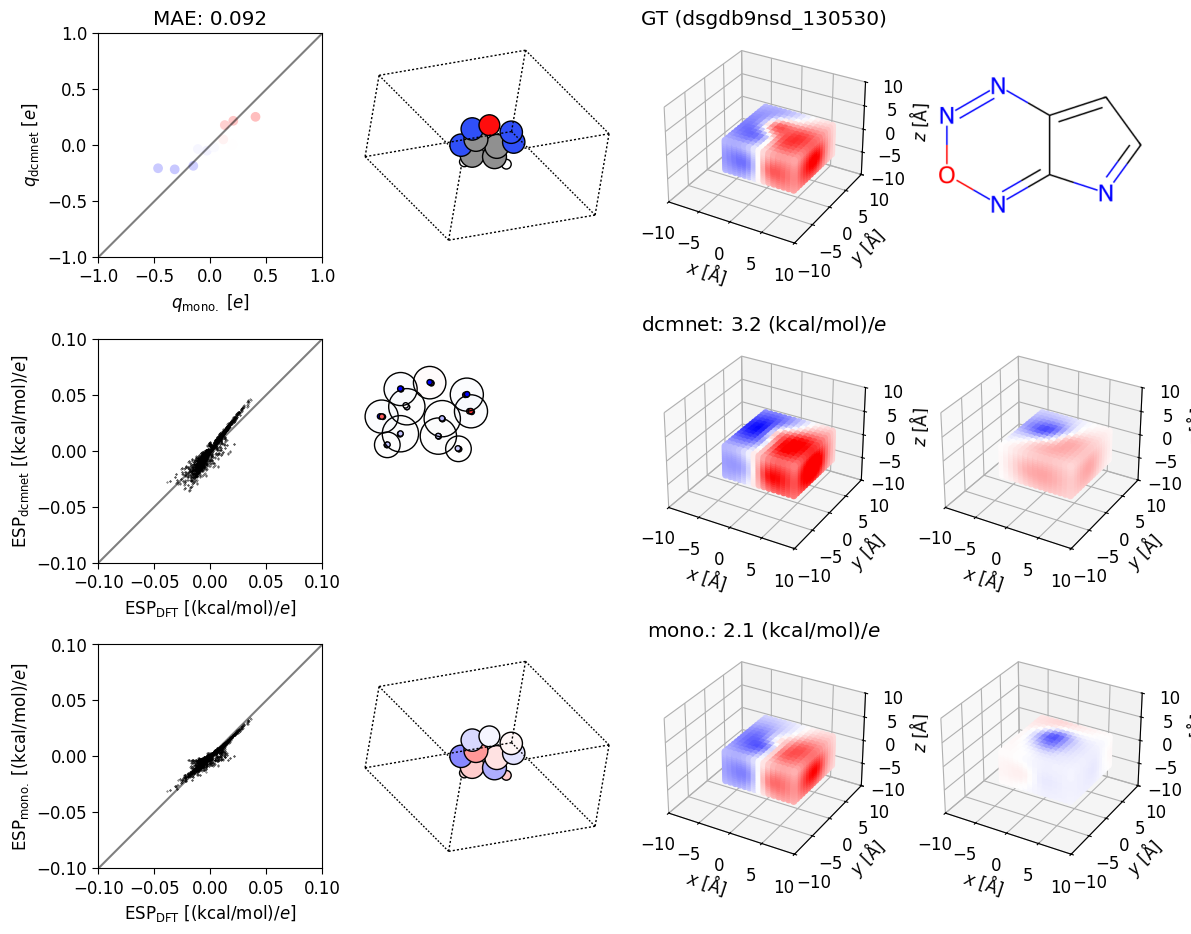

 40%|██████████████████████████████████████▍                                                         | 2/5 [00:11<00:17,  5.75s/it]

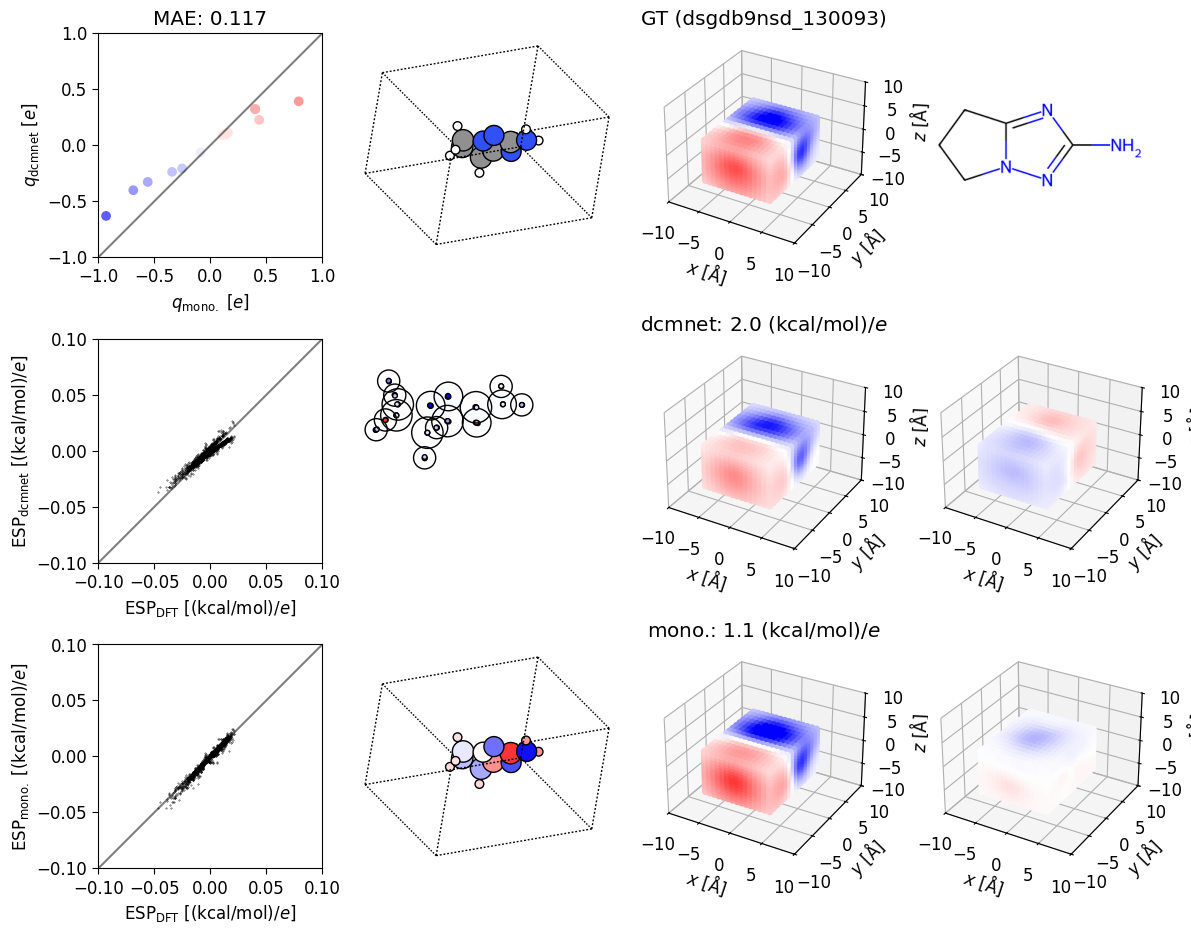

 60%|█████████████████████████████████████████████████████████▌                                      | 3/5 [00:20<00:14,  7.04s/it]

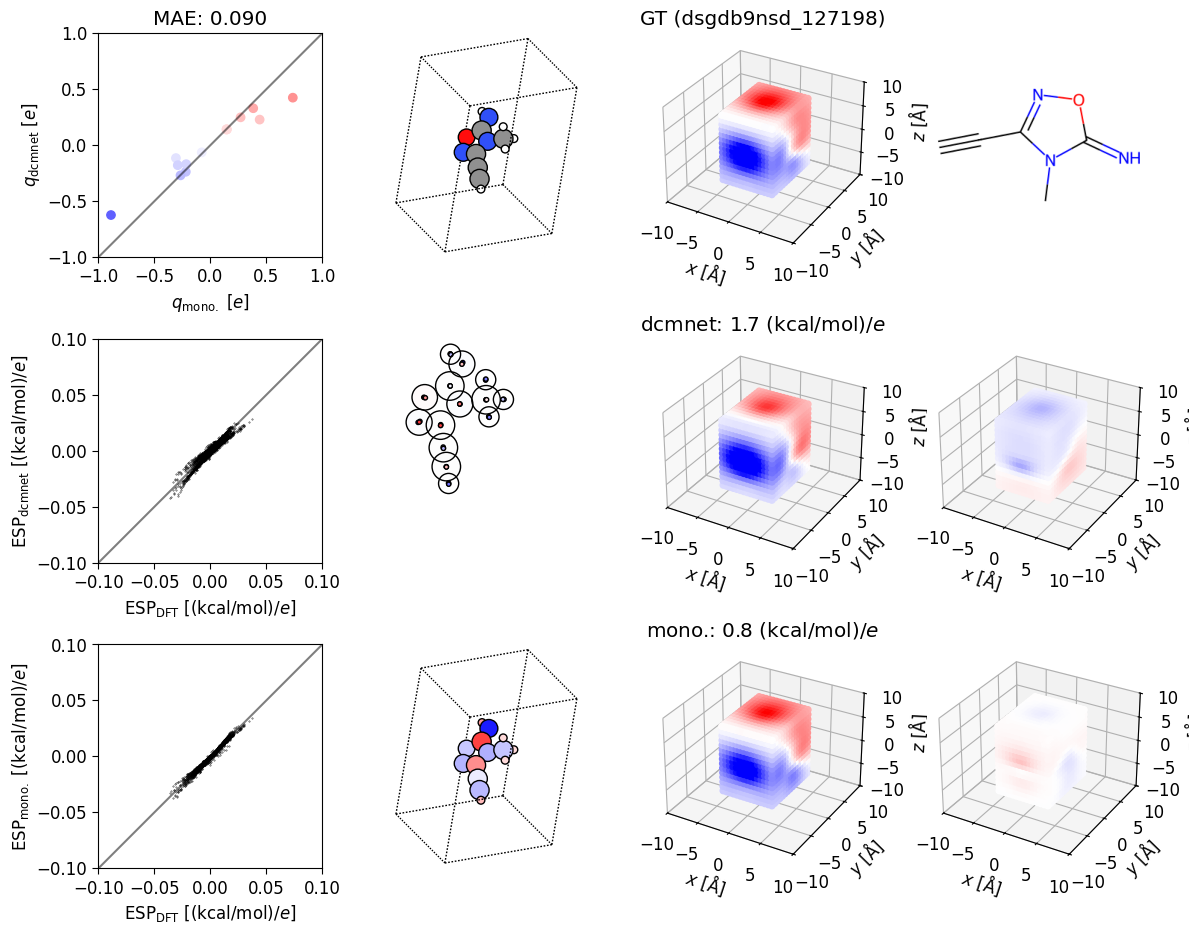

 80%|████████████████████████████████████████████████████████████████████████████▊                   | 4/5 [00:26<00:06,  6.60s/it]

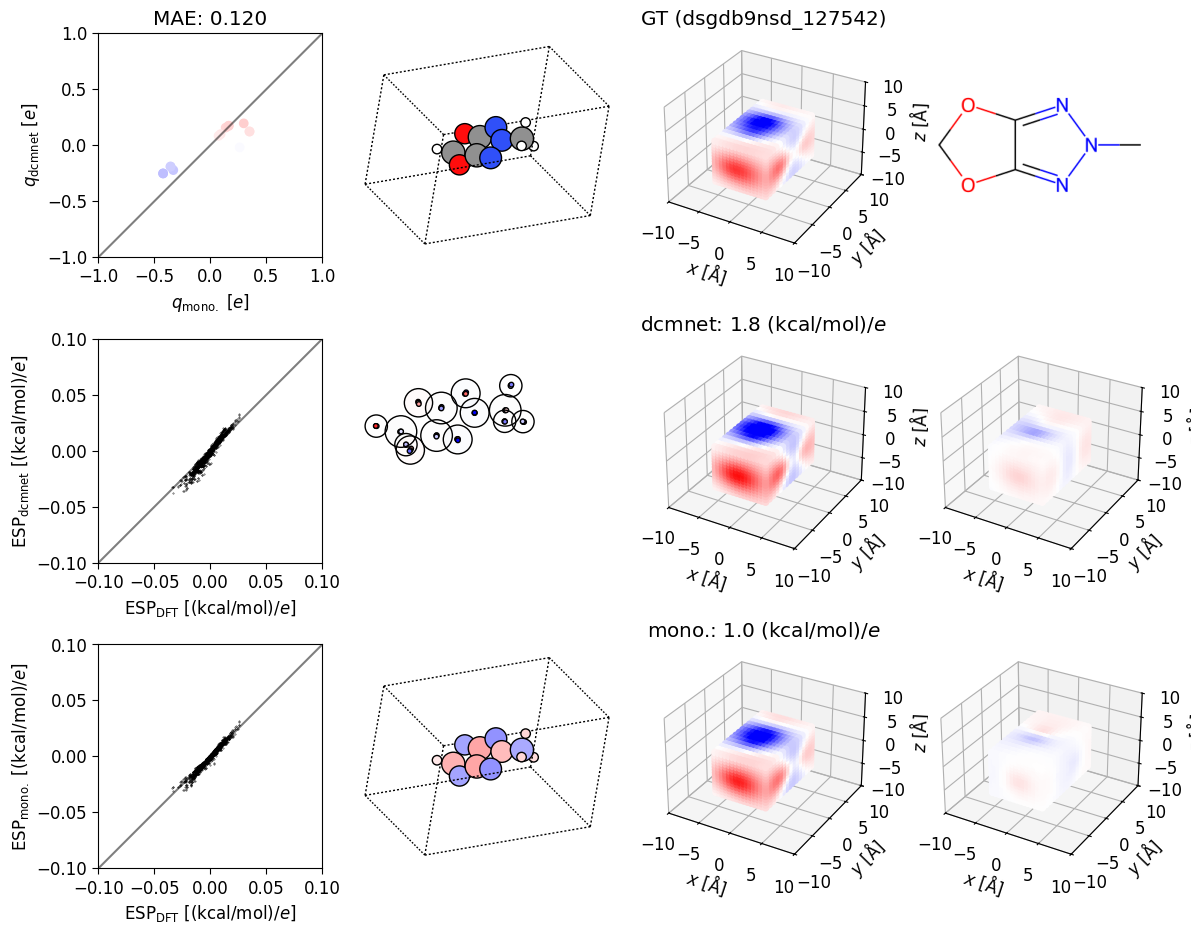

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.38s/it]


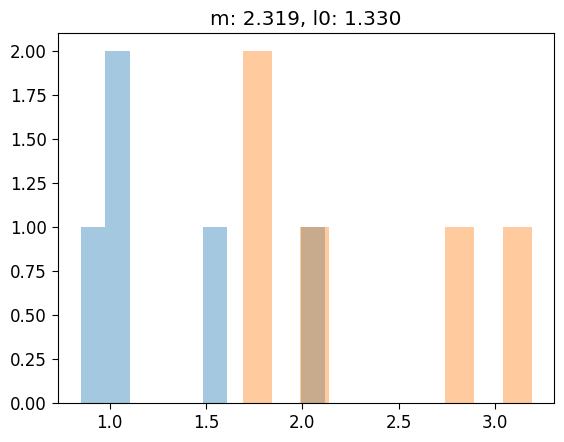

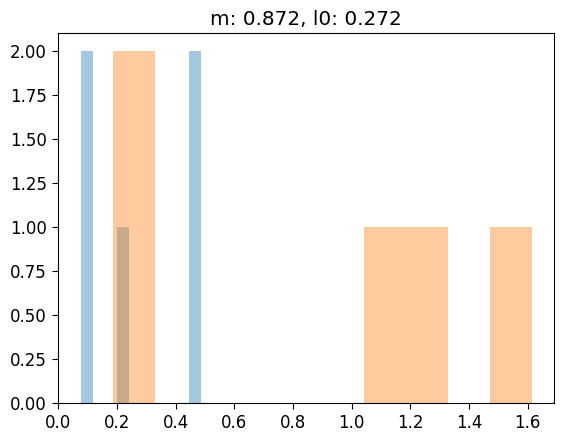

In [1791]:
esp_errors = []
dipole_errors = []
indexes = []
for i in tqdm(bad[:5]):
    batch = valid_batches[i]
    mono_test = batch["mono"]
    positions_test = batch["R"]
    D_test = batch["D"][0]
    com_test = batch["com"][0]
    
    mono, dipo = apply_model(model, params, batch, 1)
    error, esp, keys, _ = evaluate_dc(batch, dipo, mono, 
                                      1, model.n_dcm,
                                           plot=True,
                                           id=True,
                                  )
    
    pred_D = atom_centered_dipole(positions_test, com_test, mono_test)
    derr = [abs(pred_D - D_test)]
    pred_D = atom_centered_dipole(dipo, com_test, mono.reshape(model.n_dcm*60, 1))
    derr.append( abs(pred_D - D_test))
    dipole_errors.append(derr)
    esp_errors.append(error)
    indexes.append(i)

m, l0 = np.array(esp_errors).T
plt.hist(l0.flatten(), alpha=0.4)
plt.hist(m.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(m):.3f}, l0: {np.mean(l0):.3f}")
plt.show()
dl0, dm = np.array(dipole_errors).T
plt.hist(dl0.flatten(), alpha=0.4)
plt.hist(dm.flatten(), alpha=0.4)
plt.title(f"m: {np.mean(dm):.3f}, l0: {np.mean(dl0):.3f}")
plt.show()

In [20]:
import ase
old_params = params

In [41]:
ddir = Path("/pchem-data/meuwly/boittier/home/jaxeq/all_runs/")

# p = ddir / "test2/20240926-195014dcm-2-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-201945dcm-2-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-201913dcm-3-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"
# p = ddir / "test2/20240926-201827dcm-4-w-10000.0-re-False-ptFalse/best_10000.0_params.pkl"

print(p)
model, params = create_model_and_params(p, debug=True)
model

/pchem-data/meuwly/boittier/home/jaxeq/all_runs/test2/20240926-195014dcm-2-w-10000.0-re-False-ptTrue/best_10000.0_params.pkl
{'features': 16.0, 'max_degree': 2.0, 'num_iterations': 2.0, 'num_basis_functions': 16.0, 'cutoff': 4.0, 'n_dcm': 2.0, 'include_pseudotensors': True, 'debug': True}


MessagePassingModelDEBUG(
    # attributes
    features = 16
    max_degree = 2
    num_iterations = 2
    num_basis_functions = 16
    cutoff = 4.0
    max_atomic_number = 17
    n_dcm = 2
    include_pseudotensors = True
)

In [42]:
# batch

In [43]:
model.apply(params,
        atomic_numbers=batch["Z"],
        positions=batch["R"],
        dst_idx=batch["dst_idx"],
        src_idx=batch["src_idx"],
        batch_segments=batch["batch_segments"],
        batch_size=1,)

basis (Array(3540, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
x (Array(60, dtype=int32, weak_type=True), Array(1, dtype=int32, weak_type=True), Array(9, dtype=int32, weak_type=True), Array(16, dtype=int32, weak_type=True))
y (Array(60, dtype=int32, we

(Array([[-0.13027617,  0.30253404],
        [-0.12713781,  0.1083419 ],
        [-0.16282171,  0.4892795 ],
        [-0.1813013 ,  0.5853135 ],
        [-0.07314949, -0.09035318],
        [-0.19290218,  0.6519272 ],
        [-0.09650492,  0.04690497],
        [-0.16717058,  0.49593192],
        [-0.13504049,  0.13594787],
        [ 0.14984298,  0.25496885],
        [ 0.15369806,  0.2245652 ],
        [ 0.1536808 ,  0.2246544 ],
        [ 0.15064433,  0.23912176],
        [ 0.10688862,  0.50504774],
        [ 0.14700331,  0.26958734],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.00927449],
        [-0.00256419,  0.009

In [24]:
params["params"].keys()

dict_keys(['Dense_0', 'Dense_1', 'Dense_2', 'Dense_3', 'Dense_4', 'Embed_0', 'MessagePass_0', 'MessagePass_1', 'TensorDense_0', 'element_bias'])

In [25]:
EMBED = params["params"]["Embed_0"]["embedding"].squeeze(axis=1).squeeze(axis=1)
EMBED.shape

(18, 16)

Text(0.5, 0, 'Feature')

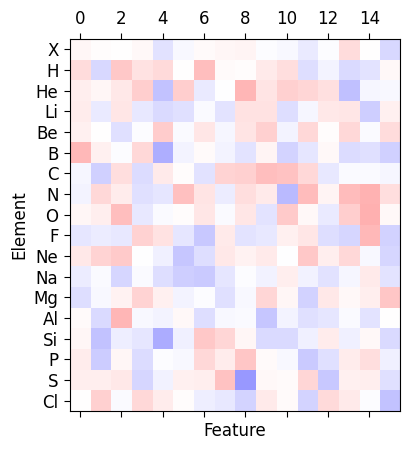

In [26]:
plt.matshow(EMBED, vmin=-2, vmax=2)
ax = plt.gca()
_ = ax.set_yticks(range(EMBED.shape[0]), ase.data.chemical_symbols[:EMBED.shape[0]])
ax.set_ylabel("Element")
ax.set_xlabel("Feature")

(3, 3, 16)


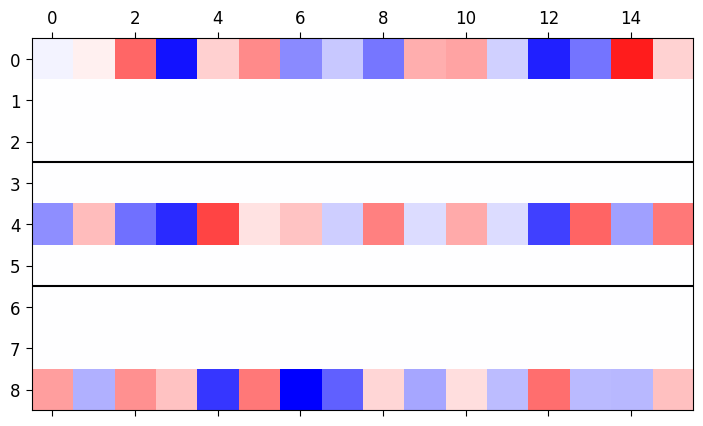

In [27]:
X = params\
    ["params"]["MessagePass_0"]["tensor"]["kernel"].squeeze()
print(X.shape)
X=X.reshape(9,16)
plt.matshow(X, vmin=-2, vmax=2)
plt.axhline(2.5, color="k")
plt.axhline(5.5, color="k")

(3, 3, 3, 16)


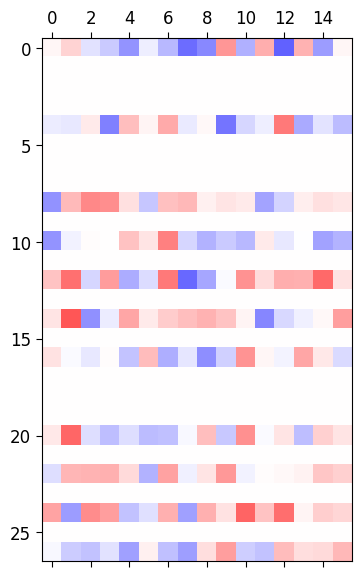

In [28]:
X = params\
    ["params"]["MessagePass_1"]["tensor"]["kernel"].squeeze()
print(X.shape)
X=X.reshape(27,16)
plt.matshow(X, vmin=-2, vmax=2)

In [29]:
params["params"]["element_bias"].shape

(18,)

In [30]:
params["params"]["Dense_1"]

{'0+': {'bias': Array([ 0.0141072 , -0.05316673, -0.09669285, -0.06426736,  0.00934727,
          0.04663379, -0.0216993 , -0.03501264, -0.01834349,  0.07624277,
          0.10812822, -0.05095945,  0.0403866 ,  0.01041475,  0.05258203,
          0.02010291], dtype=float32),
  'kernel': Array([[ 0.00502845,  0.13595615, -0.23767696,  0.34492862,  0.1887729 ,
           0.01229917, -0.34557948,  0.20308322, -0.11813527, -0.41997468,
          -0.08059055, -0.29446453,  0.00092974,  0.17186007, -0.4344278 ,
           0.40183884],
         [ 0.4021631 ,  0.39312702, -0.36236483, -0.35733476,  0.20903042,
           0.09811298, -0.661118  , -0.2605497 ,  0.3235886 , -0.41591355,
          -0.25679162,  0.11832714, -0.2591433 ,  0.10515332, -0.2471581 ,
           0.0877508 ],
         [ 0.05812385,  0.35234284, -0.28124523,  0.07764624, -0.13172965,
           0.25180662,  0.5113932 ,  0.37286362, -0.23589136,  0.3005579 ,
          -0.40852588, -0.26309833,  0.02278509, -0.5358508 ,  0.17

In [31]:
DENSE0 = params["params"]["Dense_0"]
DENSE0.keys()

dict_keys(['0+', '1-', '2+'])

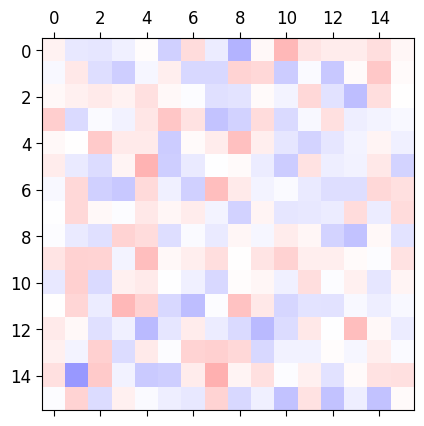

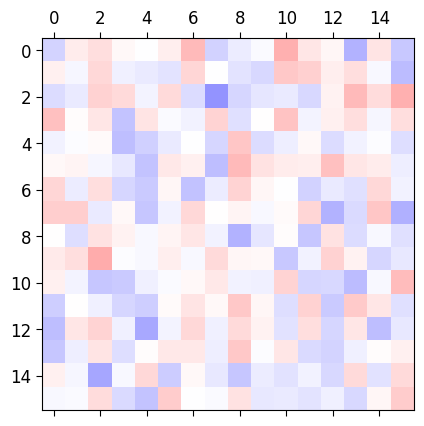

In [32]:
plt.matshow(DENSE0["0+"]["kernel"], vmin=-2, vmax=2)
plt.matshow(DENSE0["1-"]["kernel"], vmin=-2, vmax=2)
# plt.colorbar()

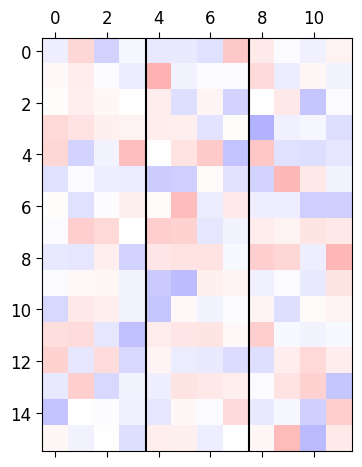

In [33]:
types = ["0+", "1-", "2+"]
X = np.array([params["params"]["TensorDense_0"]["dense"][_]["kernel"].T for _ in types]).reshape(12,16).T
plt.matshow(X, vmin=-2, vmax=2)
plt.axvline(3.5, color="k")
plt.axvline(7.5, color="k")

In [34]:
# params["params"]["TensorDense_0"]

In [35]:
X = params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze() #.reshape(9,4)
# X.shape, X

In [36]:
X = params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze().reshape(9,4)
X.shape

(9, 4)

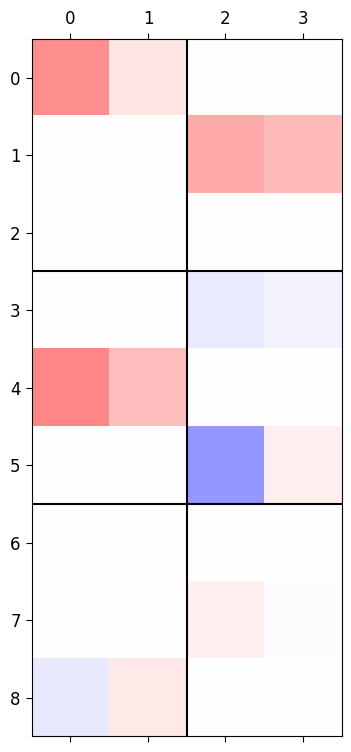

In [37]:
plt.matshow(X, vmin=-2, vmax=2)
plt.axhline(2.5, c="k")
plt.axhline(5.5, c="k")
plt.axvline(1.5, c="k")

In [38]:
X.shape

(9, 4)

In [39]:
params["params"]["TensorDense_0"]["tensor"]["kernel"].squeeze().shape

(3, 3, 2, 2)